# Detecting dog breeds


## How to run this notebook

This google collab notebook will import an existing pretrained model, and use the model to detect dogs breeds using your own personal images.

*   This notebook must be run in a google collab workspace or jupyter notebook space. Please ensure your google collab workspace directory contains the following files and folder structure:

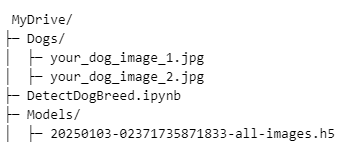


1.   Place all your images inside the /Dogs folder. You may use as many images as you wish. All detectable breeds for which this model was trained can be found in the unique_breads array later on in this notebook.

2.   Run this entire notebook. In google collab, the default shortcut is ctrl + f9, or you can click Runtime -> Run All .

3. At the bottom of the notebook under the header "Test your own images", you will find all your images displayed as well as the predicted dog breed for each.


## How was this model built?

This type of identification problem in machine learning is called "multi-class image classification". It's multi-class because we're trying to classify mutliple different breeds of dog.

Our goal is to build a model capable of detecting and labeling dog breeds. So from a high level, our model needs to be capable of 2 things.
1. Be able to recognize different colors at different pixel locations in an image and identify patterns.
2. Use these pixel paterns and shapes to classify the breed of the dog.

Of course, building an entire machine learning model from scratch which specializes in classifying images is extremely time consuming. Since the goal is not to re-invent image classification models, but rather to focus on using image classification to detect dog breeds, we can utilize a technique called **Transfer Learning**.


**Transfer learning** is the idea of using an already existing model which specializes in a specific domain/function, and then applying it to another similar problem. In our case, TensorFlow Hub is a website which contains many pre-trained image classification models.  There is also lot's of existing data out there on different dog breeds through websites such as Kaggle. So what we can do is download a model from TensorFlow Hub which specializes in classifying images, and then use transfer learning to further train that model on a dog breed dataset from Kaggle. This will result in a model which can look at images by analyzing RGB() patterns in pixels, and using the patterns to identify dog breeds. Therefore, the following 6 steps were taken to train this model:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

## Run Helper Functions and imports

In [37]:
import os
import tf_keras as keras
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

In [38]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [39]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [40]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [41]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
unique_breeds = ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
       'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael',
       'ibizan_hound', 'irish_setter', 'irish_terrier',
       'irish_water_spaniel', 'irish_wolfhound', 'italian_greyhound',
       'japanese_spaniel', 'keeshond', 'kelpie', 'kerry_blue_terrier',
       'komondor', 'kuvasz', 'labrador_retriever', 'lakeland_terrier',
       'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese_dog',
       'mexican_hairless', 'miniature_pinscher', 'miniature_poodle',
       'miniature_schnauzer', 'newfoundland', 'norfolk_terrier',
       'norwegian_elkhound', 'norwich_terrier', 'old_english_sheepdog',
       'otterhound', 'papillon', 'pekinese', 'pembroke', 'pomeranian',
       'pug', 'redbone', 'rhodesian_ridgeback', 'rottweiler',
       'saint_bernard', 'saluki', 'samoyed', 'schipperke',
       'scotch_terrier', 'scottish_deerhound', 'sealyham_terrier',
       'shetland_sheepdog', 'shih-tzu', 'siberian_husky', 'silky_terrier',
       'soft-coated_wheaten_terrier', 'staffordshire_bullterrier',
       'standard_poodle', 'standard_schnauzer', 'sussex_spaniel',
       'tibetan_mastiff', 'tibetan_terrier', 'toy_poodle', 'toy_terrier',
       'vizsla', 'walker_hound', 'weimaraner', 'welsh_springer_spaniel',
       'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier']

## Load the Model



In [44]:
loaded_full_model = load_model('drive/MyDrive/MLProjects/Models/20250103-02371735871833-all-images.h5')

Loading saved model from: drive/MyDrive/MLProjects/Models/20250103-02371735871833-all-images.h5


## How was this model built? (Optional)

This type of identification problem in machine learning is called "multi-class image classification". It's multi-class because we're trying to classify mutliple different breeds of dog.

Our goal is to build a model capable of detecting and labeling dog breeds. So from a high level, our model needs to be capable of 2 things.
1. Be able to recognize different colors at different pixel locations in an image and identify patterns.
2. Use these pixel paterns and shapes to classify the breed of the dog.

Of course, building an entire machine learning model from scratch which specializes in classifying images is extremely time consuming. Since the goal is not to re-invent image classification models, but rather to focus on using image classification to detect dog breeds, we can utilize a technique called **Transfer Learning**.


**Transfer learning** is the idea of using an already existing model which specializes in a specific domain/function, and then applying it to another similar problem. In our case, TensorFlow Hub is a website which contains many pre-trained image classification models.  There is also lot's of existing data out there on different dog breeds through websites such as Kaggle. So what we can do is download a model from TensorFlow Hub which specializes in classifying images, and then use transfer learning to further train that model on a dog breed dataset from Kaggle. This will result in a model which can look at images by analyzing RGB() patterns in pixels, and using the patterns to identify dog breeds. Therefore, the following 6 steps were taken to train this model:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

To view the full training and workflow, please visit https://github.com/nickroxcks/Machine_Learning_Projects/DogBreed_ImageClassification/end-to-end-dog-vision.ipynyb

## Test your own images



In [45]:
# Get custom image filepaths
custom_path = "drive/MyDrive/MLProjects/Dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)


Creating test data batches...
1/1 [==============================] - 1s 1s/step


Now that predictions have been made on our data, let's look at the predictions more closely

In [46]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['italian_greyhound', 'pug', 'bloodhound', 'cocker_spaniel']

In [47]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

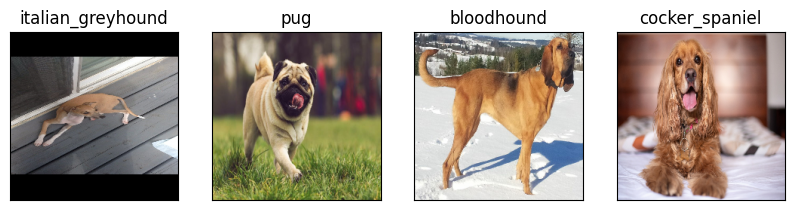

In [49]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, len(custom_pred_labels), i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)